In [1]:
#!pip install -q transformers datasets

## Loading the Data

In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Reusing dataset cifar10 (/home/cgarcia37/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_ds


Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

In [4]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], names_file=None, id=None)}

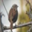

In [5]:
train_ds[0]['img']

In [6]:
train_ds[0]['label']

2

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
id2label[train_ds[0]['label']]

'bird'

## Preprocessing

In [9]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [10]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

In [11]:
# Data augmentation
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [12]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [13]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F083C0E66D0>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7F083C0E6970>],
 'label': [2, 4],
 'pixel_values': [tensor([[[ 0.2471,  0.2471,  0.2471,  ...,  0.4353,  0.4353,  0.4353],
           [ 0.2471,  0.2471,  0.2471,  ...,  0.4353,  0.4353,  0.4353],
           [ 0.2471,  0.2471,  0.2471,  ...,  0.4353,  0.4353,  0.4353],
           ...,
           [-0.3020, -0.3020, -0.3020,  ...,  0.0745,  0.0745,  0.0745],
           [-0.3020, -0.3020, -0.3020,  ...,  0.0745,  0.0745,  0.0745],
           [-0.3020, -0.3020, -0.3020,  ...,  0.0745,  0.0745,  0.0745]],
  
          [[ 0.2314,  0.2314,  0.2314,  ...,  0.2549,  0.2549,  0.2549],
           [ 0.2314,  0.2314,  0.2314,  ...,  0.2549,  0.2549,  0.2549],
           [ 0.2314,  0.2314,  0.2314,  ...,  0.2549,  0.2549,  0.2549],
           ...,
           [-0.3176, -0.3176, -0.3176,  ..., -0.0431, -0.0431, -0.0431],
           [-0.3176, -0.3176, 

In [14]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [16]:
test_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 2000
})

In [17]:
# ## Pipeline
# from transformers import ViTForImageClassification

# model_pipeline = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# model_pipeline.eval(test_ds.features[1])

## Model

In [35]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /home/cgarcia37/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
  },
  "

In [37]:
print(model.classifier)

Linear(in_features=768, out_features=10, bias=True)


In [32]:
#print(model.config)

In [21]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [22]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [24]:
# # Start tensorboard.
# #!pip install tensorboard
# %load_ext tensorboard
# %tensorboard --logdir logs/

In [25]:
trainer.train()

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running training *****
  Num examples = 4500
  Num Epochs = 0
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 1
  

ZeroDivisionError: float division by zero

## Evaluation

loading configuration file https://huggingface.co/google/vit-base-patch16-224-in21k/resolve/main/config.json from cache at /home/cgarcia37/.cache/huggingface/transformers/7bba26dd36a6ff9f6a9b19436dec361727bea03ec70fbfa82b70628109163eaa.92995a56e2eabab0c686015c4ad8275b4f9cbd858ed228f6a08936f2c31667e7
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
  },
  "

{'test_loss': 2.2988173961639404, 'test_accuracy': 0.106, 'test_runtime': 11.6281, 'test_samples_per_second': 171.997, 'test_steps_per_second': 10.75}


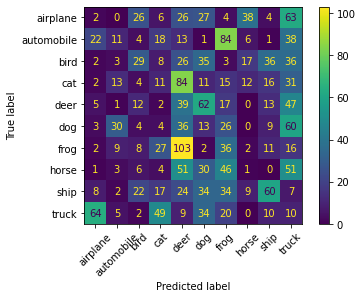

In [28]:
## Pipeline
from transformers import ViTForImageClassification
model_pipeline = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id)
trainer2 = Trainer(
    model_pipeline,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)
outputs_pipeline = trainer2.predict(test_ds)
print(outputs_pipeline.metrics)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true1 = outputs_pipeline.label_ids
y_pred1 = outputs_pipeline.predictions.argmax(1)

labels1 = train_ds.features['label'].names
cm1 = confusion_matrix(y_true1, y_pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels1)
disp1.plot(xticks_rotation=45)

In [27]:
outputs = trainer.predict(test_ds)

/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running Prediction *****
  Num examples = 2000
  Batch size = 16
/home/cgarcia37/anaconda3/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [28]:
print(outputs.metrics)

{'test_loss': 1.0758171081542969, 'test_accuracy': 0.948, 'test_runtime': 12.7093, 'test_samples_per_second': 157.365, 'test_steps_per_second': 9.835}


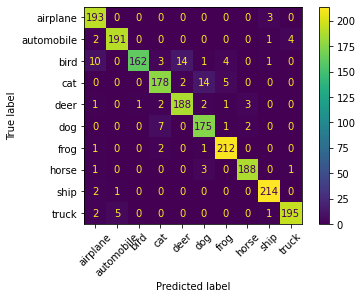

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## New Head